
Sphere: 2D


In [1]:
pip install pyGPGO


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.8 MB/s 
     |████████████████████████████████| 872 kB 43.8 MB/s 
  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19879 sha256=09d6c5ade3a245ee7231e8c317889826eec445013fd669f7fa29c476fb13fe4a
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
  Created wheel for Theano-PyMC: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=3120b27f2341dd76e7d84b7ca01e80f5ba2ad47b92d199dabd93b13a01b7cdd8
  Stored in directory: /root/.cache/pip/wheels/f3/af/8c/5dd7553522d74c52a7813806fc7ee1a9caa20a3f7c8fd850d5
Successfully built pyGPGO Theano-PyMC


In [2]:
### 1. Import python modules/packages required:

import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import warnings
import itertools
import seaborn as sns
import time

from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.tStudentProcess import tStudentProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential
from joblib import Parallel, delayed
from scipy.linalg import inv
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.stats import t
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [3]:
### Inputs:

func = 'Sphere'
n_test = 500
eps = 1e-08

util = 'ERM'

n_init = 5 # random initialisations
iters = 20
opt = True

df = 3

In [4]:
### Objective Function - Sphere(x) 2-D:

def objfunc(x1_training, x2_training):
            return  operator * ( x1_training ** 2
                            + x2_training ** 2
                            )
        
# Constraints:
lb = -5.12
ub = +5.12
    
# Input array dimension(s):
dim = 2

# 2-D inputs' parameter bounds:
param = {'x1_training': ('cont', [lb, ub]),
                 'x2_training': ('cont', [lb, ub])
                 }
    
# True y bounds:
y_lb = 0
operator = -1 # targets global minimum 
y_global_orig = y_lb * operator # targets global minimum
    
# Test data:
x1_test = np.linspace(lb, ub, n_test)
x2_test = np.linspace(lb, ub, n_test)
x_test = np.column_stack((x1_test, x2_test))


In [5]:
n_start_AcqFunc = iters
inverse = -1


In [6]:
### Cumulative Regret Calculators:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
  
def acqFuncExact(x):
    new_array = []
    x = np.array(x) 
    for i, num in enumerate(x):
            new_array = x[:-2][::-3]
    return new_array[::-1]

def acqFuncApprox(x):
    new_array = []
    x = np.array(x) 
    for i, num in enumerate(x):
            new_array = x[:-1][::-3]
    return new_array[::-1]


In [7]:
### Surrogate derivatives: 

cov_func = squaredExponential()

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)
   
def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dtStudentProcess(tStudentProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the STP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        
        smd_adj = (self.nu + self.beta1 - 2) / (self.nu + self.n1 - 2)

        alpha = np.dot(np.linalg.inv(self.K11 + (self.covfunc.sigman**2) * np.eye(len(self.X))), self.y)
        alpha_Kstar = np.dot(np.linalg.inv(self.K11 + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)      
        
        dm = np.dot(dKstar, alpha)
        ds = -2 * smd_adj * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds 
        

In [8]:
### Add exact acquisition function gradient as attribute:

class Acquisition_grad(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'ERM': self.ERM
        }

        self.f = mode_dict[mode]
    
    def ERM(self, tau, mean, std, ds, dm, nu=3.0):
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * t.cdf(gamma, df=nu) + (nu + gamma ** 2)/(nu - 1) * t.pdf(gamma, df=nu))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * (t.cdf(gamma, df=nu) * dmdx + gamma * t.pdf(gamma, df=nu) \
            * (1 - (nu + gamma ** 2)/(nu - 1) + 2/(nu - 1) * dmdx))
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, tau, mean, std, ds, dm, nu=3.0):
    
        return self.f(tau, mean, std, ds, dm, nu=3.0, **self.params)
        

In [9]:
## GPGO_multi: 

class GPGO_multi(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t        Exact ERM: StdDev. x \t Approx ERM: StdDev. x '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm, nu=3.0)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm, nu=3.0)

        return -f
   
    def _optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.x_best_std = np.std(x_best)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr        
        self.history.append(self.x_best_std)

        x_best_exact = np.empty((n_start, len(self.parameter_key)))
        f_best_exact = np.empty((n_start,))
        opt_exact = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_exact = np.array([res.x for res in opt_exact])
        f_best_exact = np.array([np.atleast_1d(res.fun)[0] for res in opt_exact])
        f_best_min_exact = min(f_best_exact)

        self.x_best_exact = x_best_exact
        self.f_best_exact = f_best_exact
        self.f_best_min_exact = f_best_min_exact
        self.x_best_std_exact = np.std(x_best_exact)
        self.best_exact = x_best_exact[np.argmin(f_best_exact)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std_exact)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        min_acqfunc_exact = str(self.f_best_min_exact)
        x_best_std = str(self.x_best_std)
        x_best_std_exact = str(self.x_best_std_exact)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            x_best_std = BOLD + OKGREEN + x_best_std + ENDC
            x_best_std_exact = BOLD + OKGREEN + x_best_std_exact + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, x_best_std_exact, x_best_std))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [10]:
## dGPGO:

class dGPGO(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t        Exact ERM: StdDev. x \t Approx ERM: StdDev. x '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'

    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm, nu=3.0)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm, nu=3.0)

        return -f

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.x_best_std = np.std(x_best)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std)

        x_best_approx = np.empty((n_start, len(self.parameter_key)))
        f_best_approx = np.empty((n_start,))
        opt_approx = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_approx = np.array([res.x for res in opt_approx])
        f_best_approx = np.array([np.atleast_1d(res.fun)[0] for res in opt_approx])
        f_best_min_approx = min(f_best_approx)

        self.x_best_approx = x_best_approx
        self.f_best_approx = f_best_approx
        self.f_best_min_approx = f_best_min_approx
        self.x_best_std_approx = np.std(x_best_approx)
        self.best_approx = x_best_approx[np.argmin(f_best_approx)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std_approx)
    
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        min_acqfunc_approx = str(self.f_best_min_approx)
        x_best_std = str(self.x_best_std)
        x_best_std_approx = str(self.x_best_std_approx)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            x_best_std = BOLD + OKGREEN + x_best_std + ENDC
            x_best_std_approx = BOLD + OKGREEN + x_best_std_approx + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, x_best_std, x_best_std_approx))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [11]:
###Reproducible set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [12]:
start_approx = time.time()
start_approx


1662459697.7792988

In [13]:
### ESTIMATED STP ERM GRADIENTS

np.random.seed(run_num_1)
surrogate_approx_1 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_1 = GPGO_multi(surrogate_approx_1, Acquisition_grad(util), objfunc, param)
approx_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-0.84969467  2.25612281]	 5.812071182014687	 1.275455677703416	    	    
init	 [-5.1188288  -2.02411446]	 30.299447634857913	 1.275455677703416	    	    
init	 [-3.61721968 -4.17445279]	 30.510334291475417	 1.275455677703416	    	    
init	 [-3.21269544 -1.58145816]	 12.822421857501787	 1.275455677703416	    	    
init	 [-1.05710106  0.39748336]	 1.275455677703416	 1.275455677703416	    	    
1  	 [ 4.04077223 -4.24914728]	 34.383092818836786	 1.275455677703416	 3.2577947648870555	 4.203794230040782
2  	 [4.31249029 5.12      ]	 44.81197246351513	 1.275455677703416	 3.0926928363828536	 3.484570110372532
3  	 [-5.12  5.12]	 52.4288	 1.275455677703416	 2.9090321996768775	 3.649622210743778
4  	 [5.12      0.3771022]	 26.356606070686162	 1.275455677703416	 2.497187326530895	 3.1832384072128415
5  	 [ 0.59372776 -2.19624032]	 5.175984189482424	 1.275455677703416	 2.58377

In [14]:
### ESTIMATED STP ERM GRADIENTS

np.random.seed(run_num_2)
surrogate_approx_2 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_2 = GPGO_multi(surrogate_approx_2, Acquisition_grad(util), objfunc, param)
approx_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-0.6554122  -4.85451539]	 23.995884788327533	 0.6972563370202991	    	    
init	 [ 0.50854377 -0.6622987 ]	 0.6972563370202991	 0.6972563370202991	    	    
init	 [-0.81543371 -1.73737143]	 3.683391625826377	 0.6972563370202991	    	    
init	 [-3.02439799  1.2213347 ]	 10.638641624769724	 0.6972563370202991	    	    
init	 [-2.05153614 -2.3876887 ]	 9.90985788235879	 0.6972563370202991	    	    
1  	 [4.81874241 3.07464552]	 32.673723450709105	 0.6972563370202991	 3.689083261142593	 3.7713928211297576
2  	 [ 4.84260546 -3.96517156]	 39.173413151255836	 0.6972563370202991	 2.4067897387824098	 3.8602995897800123
3  	 [-0.00881318  5.12      ]	 26.214477672135438	 0.6972563370202991	 3.3835033382631337	 3.956094042276509
4  	 [-5.12  5.12]	 52.4288	 0.6972563370202991	 3.2122926580239435	 3.2027600378899512
5  	 [-5.12 -5.12]	 52.4288	 0.6972563370202991	 3.67422954266

In [15]:
### ESTIMATED STP ERM GRADIENTS

np.random.seed(run_num_3)
surrogate_approx_3 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_3 = GPGO_multi(surrogate_approx_3, Acquisition_grad(util), objfunc, param)
approx_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [0.52017052 2.1314337 ]	 4.813587005218131	 4.59675431006429	    	    
init	 [-2.14113547  0.11087468]	 4.59675431006429	 4.59675431006429	    	    
init	 [4.02377681 4.05804123]	 32.65847846685941	 4.59675431006429	    	    
init	 [-3.83400642 -2.99783293]	 23.686607498512902	 4.59675431006429	    	    
init	 [-4.59297584 -0.6061072 ]	 21.462792989409664	 4.59675431006429	    	    
1  	 [ 2.87042319 -1.98283743]	 12.170973549365186	 4.59675431006429	 2.4386198472052447	 2.5784722805022087
2  	 [-3.95360718  5.12      ]	 41.845409723662854	 4.59675431006429	 2.9146509141947536	 3.9820702247011734
3  	 [ 0.06158407 -5.12      ]	 26.21819259782574	 4.59675431006429	 2.7040040660731024	 3.3742098230470887
4  	 [ 5.12 -5.12]	 52.4288	 4.59675431006429	 2.9804221458346016	 2.9703258962008716
5  	 [0.06462252 5.12      ]	 26.218576070632956	 4.59675431006429	 2.499646577827

In [16]:
### ESTIMATED STP ERM GRADIENTS

np.random.seed(run_num_4)
surrogate_approx_4 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_4= GPGO_multi(surrogate_approx_4, Acquisition_grad(util), objfunc, param)
approx_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [4.78238555 0.48365823]	 23.1051368481516	 6.844040613967918	    	    
init	 [4.84028785 2.19971578]	 28.267135924302462	 6.844040613967918	    	    
init	 [ 2.02474316 -2.90724357]	 12.551650027390728	 6.844040613967918	    	    
init	 [ 4.87705042 -5.05620219]	 49.3508013219099	 6.844040613967918	    	    
init	 [-2.52946061 -0.66773471]	 6.844040613967918	 6.844040613967918	    	    
1  	 [-2.48825446  4.69465063]	 28.231154823783243	 6.844040613967918	 2.688392261113429	 3.7441273981326666
2  	 [-5.12 -5.12]	 52.4288	 6.844040613967918	 3.9284811704684697	 3.753159583349691
3  	 [1.80400057 5.12      ]	 29.468818060450324	 6.844040613967918	 3.31906153709231	 3.3344582288612115
4	 [0.64167696 1.12296837]	 1.6728072834893526	 1.6728072834893526	 3.1360622329532846	 3.3195698502567956
5  	 [-0.95736979 -5.12      ]	 27.13095691115869	 1.6728072834893526	 2.945475686

In [17]:
### ESTIMATED STP ERM GRADIENTS

np.random.seed(run_num_5)
surrogate_approx_5 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_5 = GPGO_multi(surrogate_approx_5, Acquisition_grad(util), objfunc, param)
approx_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-2.84678993  3.79629882]	 22.516097589112718	 1.3234068721819314	    	    
init	 [-3.00319585  4.2865757 ]	 27.393916517947076	 1.3234068721819314	    	    
init	 [-0.11866943  1.14425716]	 1.3234068721819314	 1.3234068721819314	    	    
init	 [2.72289645 0.1886002 ]	 7.449735113237491	 1.3234068721819314	    	    
init	 [-2.08076286 -3.19773462]	 14.555080786026249	 1.3234068721819314	    	    
1  	 [ 4.32895605 -5.09732646]	 44.722597532365825	 1.3234068721819314	 4.375918890183728	 4.534779838354806
2  	 [5.12       4.86210298]	 49.85444539567493	 1.3234068721819314	 3.804980593868448	 3.615406268755816
3  	 [-5.12       -0.04790741]	 26.216695119683738	 1.3234068721819314	 3.349108197342107	 3.624634825778117
4  	 [0.97278913 5.12      ]	 27.160718687553892	 1.3234068721819314	 3.2273700403144843	 3.406643966061913
5  	 [-5.12 -5.12]	 52.4288	 1.3234068721819314

In [18]:
### ESTIMATED STP ERM GRADIENTS

np.random.seed(run_num_6)
surrogate_approx_6 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_6 = GPGO_multi(surrogate_approx_6, Acquisition_grad(util), objfunc, param)
approx_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [ 4.02288795 -1.72052679]	 19.143839911819178	 0.7844720799352826	    	    
init	 [ 3.28938622 -4.69302655]	 32.84455992822337	 0.7844720799352826	    	    
init	 [-4.0175956   0.97333314]	 17.088451781196223	 0.7844720799352826	    	    
init	 [ 0.30532979 -0.83141193]	 0.7844720799352826	 0.7844720799352826	    	    
init	 [-1.68542362  1.25459899]	 4.414671405342624	 0.7844720799352826	    	    
1  	 [3.42535861 5.12      ]	 37.947481623400705	 0.7844720799352826	 3.6063723876241744	 3.7426273288781267
2  	 [-5.12       -4.38937332]	 45.48099810013264	 0.7844720799352826	 3.5097616996876817	 3.551756930582981
3  	 [-5.12  5.12]	 52.4288	 0.7844720799352826	 3.451964878346549	 3.7311485317310167
4  	 [-0.89639511 -5.12      ]	 27.017924186590697	 0.7844720799352826	 3.202809370832567	 3.3801588287574957
5  	 [-0.79904984  5.12      ]	 26.852880653606583	 0.784472079

In [19]:
### ESTIMATED STP ERM GRADIENTS

np.random.seed(run_num_7)
surrogate_approx_7 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_7 = GPGO_multi(surrogate_approx_7, Acquisition_grad(util), objfunc, param)
approx_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-4.33860312  2.86636843]	 27.039544996254122	 5.622519010932044	    	    
init	 [-0.63068947  2.28828342]	 5.634010222398341	 5.622519010932044	    	    
init	 [4.8946126  0.39419771]	 24.112624368867845	 5.622519010932044	    	    
init	 [ 0.01147355 -4.38219639]	 19.20377688135857	 5.622519010932044	    	    
init	 [-2.37118484e+00 -1.20319155e-03]	 5.622519010932044	 5.622519010932044	    	    
1  	 [ 5.12 -5.12]	 52.4288	 5.622519010932044	 2.845158992446571	 3.137875959348832
2  	 [-5.12 -5.12]	 52.4288	 5.622519010932044	 4.106669627896568	 4.182661241718393
3  	 [3.3316904 5.12     ]	 37.314560904489014	 5.622519010932044	 3.270265974487891	 3.3836675418471325
4  	 [-4.02558214 -1.33646422]	 17.991448177385568	 5.622519010932044	 2.886315604141263	 3.046307140328312
5	 [ 1.22410147 -0.77336959]	 2.0965249354570203	 2.0965249354570203	 3.057410524940702	 2.8935

In [20]:
### ESTIMATED STP ERM GRADIENTS

np.random.seed(run_num_8)
surrogate_approx_8 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_8 = GPGO_multi(surrogate_approx_8, Acquisition_grad(util), objfunc, param)
approx_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [3.82391708 4.79785639]	 37.641767782829874	 0.10287109474532606	    	    
init	 [3.78055209 0.31596228]	 14.392406282091054	 0.10287109474532606	    	    
init	 [-2.73686192 -5.00327624]	 32.52318635319257	 0.10287109474532606	    	    
init	 [-0.7119993  -0.99992207]	 1.5067871566831337	 0.10287109474532606	    	    
init	 [ 0.23218863 -0.22126801]	 0.10287109474532606	 0.10287109474532606	    	    
1  	 [-0.60136285  2.7645328 ]	 8.004278866775978	 0.10287109474532606	 3.2635182269052483	 3.738703564974227
2  	 [ 5.12      -4.9830254]	 51.044942112722936	 0.10287109474532606	 3.2041790083138753	 3.7311887645628325
3  	 [-5.12  5.12]	 52.4288	 0.10287109474532606	 2.684164349472631	 3.6332670170659704
4  	 [-5.12       -0.25161628]	 26.277710751239166	 0.10287109474532606	 3.0402486367630903	 3.36368930431313
5  	 [ 1.1936463  -3.64773257]	 14.730744415201274	 0.102

In [21]:
### ESTIMATED STP ERM GRADIENTS

np.random.seed(run_num_9)
surrogate_approx_9 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_9 = GPGO_multi(surrogate_approx_9, Acquisition_grad(util), objfunc, param)
approx_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-5.01376866  0.01919582]	 25.138244697862262	 7.349882113053805	    	    
init	 [-0.04328148 -3.74958562]	 14.061265633999861	 7.349882113053805	    	    
init	 [-3.66478248 -2.88195916]	 21.736319271030034	 7.349882113053805	    	    
init	 [-0.83447623 -2.57944404]	 7.349882113053805	 7.349882113053805	    	    
init	 [-4.25922917 -1.58209393]	 20.64405433050371	 7.349882113053805	    	    
1  	 [3.11029524 4.9495987 ]	 34.172463819640285	 7.349882113053805	 2.774579746007222	 3.0473536611845535
2  	 [ 5.12       -0.43496757]	 26.403596784886062	 7.349882113053805	 2.8560672501982083	 3.980936431100248
3  	 [-2.72757059  5.12      ]	 33.654041318969135	 7.349882113053805	 2.8511650587445394	 3.9558812925441473
4  	 [ 4.93171526 -5.12      ]	 50.53621543019305	 7.349882113053805	 2.939893838206961	 3.2236218300886916
5	 [0.187669   1.38191445]	 1.9449072001869563	 1

In [22]:
### ESTIMATED STP ERM GRADIENTS

np.random.seed(run_num_10)
surrogate_approx_10 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_10 = GPGO_multi(surrogate_approx_10, Acquisition_grad(util), objfunc, param)
approx_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [ 2.77832339 -4.90750004]	 31.80263747150094	 7.941821858928501	    	    
init	 [1.36855793 2.54775176]	 8.363989812138083	 7.941821858928501	    	    
init	 [-0.01528819 -2.81808235]	 7.941821858928501	 7.941821858928501	    	    
init	 [-3.09183626  2.66783449]	 16.67679237031191	 7.941821858928501	    	    
init	 [-3.38830503 -4.2154003 ]	 29.25021071405309	 7.941821858928501	    	    
1  	 [ 5.12       -0.36591025]	 26.34829030752475	 7.941821858928501	 3.146128583104609	 3.475831178217413
2  	 [5.12 5.12]	 52.4288	 7.941821858928501	 2.934589610302016	 2.830946283488092
3  	 [-5.12       -0.59625039]	 26.56991452293248	 7.941821858928501	 2.9233790503938692	 2.9308880716327828
4  	 [-0.58529462  5.12      ]	 26.55696979288194	 7.941821858928501	 3.0859638270473218	 3.412332318522582
5  	 [-5.12  5.12]	 52.4288	 7.941821858928501	 2.5848347682925326	 3.02917076354

In [23]:
### ESTIMATED STP ERM GRADIENTS

np.random.seed(run_num_11)
surrogate_approx_11 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_11 = GPGO_multi(surrogate_approx_11, Acquisition_grad(util), objfunc, param)
approx_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-3.27403839 -4.92057353]	 34.93137118861299	 0.6899456214148796	    	    
init	 [-0.37664229  2.30332343]	 5.447158259491397	 0.6899456214148796	    	    
init	 [-0.81711509 -0.14922651]	 0.6899456214148796	 0.6899456214148796	    	    
init	 [-4.98912446 -0.12931474]	 24.908085165573997	 0.6899456214148796	    	    
init	 [4.52410012 3.59214172]	 33.37096399795931	 0.6899456214148796	    	    
1  	 [ 3.03550212 -4.46785095]	 29.17596522689979	 0.6899456214148796	 2.8541622788938295	 3.781318374332612
2  	 [-4.80064541  5.12      ]	 49.26059639020582	 0.6899456214148796	 2.2293187093014604	 3.2947126647737113
3  	 [ 5.12       -0.71939979]	 26.73193606264244	 0.6899456214148796	 2.8555795120540433	 2.987910617269751
4  	 [0.93036291 5.12      ]	 27.07997515286353	 0.6899456214148796	 2.5595267736180816	 2.5785100134197334
5  	 [-0.19471125 -2.63796404]	 6.99676672425

In [24]:
### ESTIMATED STP ERM GRADIENTS

np.random.seed(run_num_12)
surrogate_approx_12 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_12 = GPGO_multi(surrogate_approx_12, Acquisition_grad(util), objfunc, param)
approx_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-3.54137249  2.45810889]	 18.583618467979093	 5.993464196233534	    	    
init	 [-2.42365424  0.34549139]	 5.993464196233534	 5.993464196233534	    	    
init	 [-4.97075238  4.28796936]	 43.09506052206225	 5.993464196233534	    	    
init	 [ 4.10332011 -4.77776458]	 39.66427028607538	 5.993464196233534	    	    
init	 [ 4.6791612  -3.71497655]	 35.6956003298903	 5.993464196233534	    	    
1  	 [5.12 5.12]	 52.4288	 5.993464196233534	 3.4319081215357548	 3.639585287597927
2  	 [-1.55358971 -5.12      ]	 28.628040976364737	 5.993464196233534	 3.0918243335200826	 2.8305770977216254
3	 [2.28101415 0.7763989 ]	 5.805820815556423	 5.805820815556423	 3.2592958992785084	 2.891919197448596
4  	 [0.22745526 5.12      ]	 26.266135894750516	 5.805820815556423	 3.062793719800256	 2.9914606797678798
5  	 [-5.12       -2.61724595]	 33.064376361926634	 5.805820815556423	 3.18840000

In [25]:
### ESTIMATED STP ERM GRADIENTS

np.random.seed(run_num_13)
surrogate_approx_13 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_13 = GPGO_multi(surrogate_approx_13, Acquisition_grad(util), objfunc, param)
approx_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [ 2.84367268 -2.68757791]	 15.30954934064491	 7.271500601275535	    	    
init	 [3.32061217 4.76927179]	 33.772418600555795	 7.271500601275535	    	    
init	 [ 4.83943541 -0.47667971]	 23.647358595121606	 7.271500601275535	    	    
init	 [1.11659482 2.82139151]	 9.20703403927425	 7.271500601275535	    	    
init	 [1.45012065 2.27346667]	 7.271500601275535	 7.271500601275535	    	    
1  	 [-4.10876704 -2.60547476]	 23.670465283396044	 7.271500601275535	 3.347237928179087	 3.3422270088598744
2  	 [-3.73043861  5.12      ]	 40.130572220202744	 7.271500601275535	 3.1100090327017575	 3.495167997192962
3  	 [-0.5946202 -5.12     ]	 26.56797318471565	 7.271500601275535	 3.0328091014116443	 2.875570683687759
4	 [-2.37546078  1.05010444]	 6.745533262210848	 6.745533262210848	 2.892727768620736	 2.734738565624782
5  	 [ 5.12 -5.12]	 52.4288	 6.745533262210848	 3.344518633273

In [26]:
### ESTIMATED STP ERM GRADIENTS

np.random.seed(run_num_14)
surrogate_approx_14 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_14 = GPGO_multi(surrogate_approx_14, Acquisition_grad(util), objfunc, param)
approx_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [0.14277984 2.79721013]	 7.844770612568215	 3.480496204392171	    	    
init	 [ 3.7931795  -5.03759925]	 39.765616906968944	 3.480496204392171	    	    
init	 [-1.94830412  4.68586229]	 25.753194366239512	 3.480496204392171	    	    
init	 [ 0.13431513 -1.86076749]	 3.480496204392171	 3.480496204392171	    	    
init	 [ 0.40140736 -2.85434939]	 8.308438305616814	 3.480496204392171	    	    
1  	 [-5.12 -5.12]	 52.4288	 3.480496204392171	 3.943071933801878	 3.766678082786296
2  	 [5.00058348 5.12      ]	 51.22023515683708	 3.480496204392171	 3.681336556636982	 3.845689383357188
3  	 [-5.12        0.39632033]	 26.37146980097051	 3.480496204392171	 2.8279971363902097	 3.6732497360836476
4  	 [ 5.12       -0.07211953]	 26.21960122627733	 3.480496204392171	 2.979597683061928	 3.176933318275151
5	 [-1.61902532  0.11433656]	 2.634315837013793	 2.634315837013793	 2.6744576173

In [27]:
### ESTIMATED STP ERM GRADIENTS

np.random.seed(run_num_15)
surrogate_approx_15 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_15 = GPGO_multi(surrogate_approx_15, Acquisition_grad(util), objfunc, param)
approx_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [ 3.57189322 -3.28810573]	 23.57006045912445	 5.383887924980681	    	    
init	 [-4.56332069 -1.41784631]	 22.834183843344235	 5.383887924980681	    	    
init	 [-2.29989449  0.3072023 ]	 5.383887924980681	 5.383887924980681	    	    
init	 [-1.9873903  -2.00218256]	 7.958455228543059	 5.383887924980681	    	    
init	 [-3.97576933 -2.5610341 ]	 22.365637431409507	 5.383887924980681	    	    
1  	 [2.7754098  2.98802689]	 16.631204280641075	 5.383887924980681	 3.2413058306438876	 3.680458659889904
2  	 [-5.12        4.65351663]	 47.86961698737859	 5.383887924980681	 2.8898250997938595	 3.642859954753749
3  	 [-0.73603909  5.12      ]	 26.756153541505782	 5.383887924980681	 3.3355886379363544	 3.865492024888126
4  	 [-0.11916361 -5.12      ]	 26.228599966057796	 5.383887924980681	 2.8624463531671713	 2.972089259226207
5  	 [5.12       0.18677606]	 26.24928529615733	 5.

In [28]:
### ESTIMATED STP ERM GRADIENTS

np.random.seed(run_num_16)
surrogate_approx_16 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_16 = GPGO_multi(surrogate_approx_16, Acquisition_grad(util), objfunc, param)
approx_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-2.83349935  0.23719262]	 8.084978900492077	 8.084978900492077	    	    
init	 [ 0.51918292 -4.65303603]	 21.92029520206884	 8.084978900492077	    	    
init	 [-1.42613673 -2.83565116]	 10.074783446012654	 8.084978900492077	    	    
init	 [ 1.9325559  -3.44339021]	 15.591708419712269	 8.084978900492077	    	    
init	 [-4.39987336  4.51595121]	 39.75270093978162	 8.084978900492077	    	    
1  	 [2.142749   4.83374619]	 27.956475467604665	 8.084978900492077	 3.550840142887768	 3.8827747554808614
2  	 [5.12       0.51596843]	 26.48062341711456	 8.084978900492077	 3.0479941142050517	 3.4876775723947615
3  	 [-5.12 -5.12]	 52.4288	 8.084978900492077	 3.360172488134032	 3.669003224855324
4	 [0.95118883 0.73957654]	 1.451733656815996	 1.451733656815996	 2.935251398797922	 3.192977280153737
5  	 [ 5.12 -5.12]	 52.4288	 1.451733656815996	 2.5895682120686514	 2.971007847678

In [29]:
### ESTIMATED STP ERM GRADIENTS

np.random.seed(run_num_17)
surrogate_approx_17 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_17 = GPGO_multi(surrogate_approx_17, Acquisition_grad(util), objfunc, param)
approx_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-2.10263037  0.31320838]	 4.519153970964611	 2.5824114132885994	    	    
init	 [-3.15882714 -4.42470033]	 29.556161939946307	 2.5824114132885994	    	    
init	 [2.93873111 1.60085526]	 11.198878112253603	 2.5824114132885994	    	    
init	 [1.40821398 0.77417363]	 2.5824114132885994	 2.5824114132885994	    	    
init	 [-4.71999574 -1.45598869]	 24.39826283453718	 2.5824114132885994	    	    
1  	 [ 4.96008736 -4.44720822]	 44.38012757656366	 2.5824114132885994	 3.2242163407014295	 4.422016526816355
2  	 [-5.12        4.62934928]	 47.645274733245955	 2.5824114132885994	 3.198822377088879	 3.299540615784581
3  	 [-0.1018174  5.12     ]	 26.224766783157282	 2.5824114132885994	 3.169919840679673	 3.3361424850926875
4  	 [5.12 5.12]	 52.4288	 2.5824114132885994	 3.3763128035447254	 3.4458399058420173
5  	 [ 0.8526048 -2.8184164]	 8.67040594971073	 2.5824114132885994	 2.

In [30]:
### ESTIMATED STP ERM GRADIENTS

np.random.seed(run_num_18)
surrogate_approx_18 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_18 = GPGO_multi(surrogate_approx_18, Acquisition_grad(util), objfunc, param)
approx_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [1.53983224 0.05584255]	 2.3742017032787373	 2.3742017032787373	    	    
init	 [ 3.87687906 -3.25795609]	 25.644469161882945	 2.3742017032787373	    	    
init	 [3.60686662 2.56139557]	 19.570234102364928	 2.3742017032787373	    	    
init	 [1.70088108 4.99604939]	 27.853505942237412	 2.3742017032787373	    	    
init	 [-2.48864335 -4.83014733]	 29.523668919355142	 2.3742017032787373	    	    
1  	 [-5.00718904  2.9174042 ]	 33.58318939621877	 2.3742017032787373	 3.0647282488550096	 3.827695887001409
2  	 [-5.12       -1.45216137]	 28.323172649819313	 2.3742017032787373	 2.6600267767465655	 2.52963910459379
3  	 [-1.15686523  1.84914376]	 4.757669799537527	 2.3742017032787373	 3.019579861293326	 3.0486814417545594
4  	 [-2.03989992  5.12      ]	 30.375591680765922	 2.3742017032787373	 2.7969328554732016	 3.2330268737739494
5  	 [-1.01586591 -1.45218434]	 3.1408228941

In [31]:
### ESTIMATED STP ERM GRADIENTS

np.random.seed(run_num_19)
surrogate_approx_19 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_19 = GPGO_multi(surrogate_approx_19, Acquisition_grad(util), objfunc, param)
approx_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-4.12125592  2.6751971 ]	 24.141429859518958	 12.957869519084127	    	    
init	 [-2.59135515 -3.70553152]	 20.446085385698954	 12.957869519084127	    	    
init	 [-1.72598719 -4.27008445]	 21.212653034418548	 12.957869519084127	    	    
init	 [1.76104531 3.13952049]	 12.957869519084127	 12.957869519084127	    	    
init	 [4.9432772  1.38916592]	 26.36577149009895	 12.957869519084127	    	    
1  	 [ 5.12       -4.68348284]	 48.149411467099846	 12.957869519084127	 3.4677723307976427	 4.449795157621861
2	 [ 1.47754945 -1.38234046]	 4.09401750218581	 4.09401750218581	 3.448186874773856	 3.3672366801971836
3  	 [5.12 5.12]	 52.4288	 4.09401750218581	 3.3344496479099894	 3.0840034271031356
4  	 [-5.12       -1.05754466]	 27.332800705223434	 4.09401750218581	 3.0085172680253995	 2.8368900801642427
5  	 [-1.25782448  5.12      ]	 27.796522420356418	 4.09401750218581	 3.00

In [32]:
### ESTIMATED STP ERM GRADIENTS

np.random.seed(run_num_20)
surrogate_approx_20 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_20 = GPGO_multi(surrogate_approx_20, Acquisition_grad(util), objfunc, param)
approx_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [0.9024594  4.07258857]	 17.400410665504328	 1.579257056101869	    	    
init	 [4.00927467 3.23417577]	 26.53417627399789	 1.579257056101869	    	    
init	 [-4.75249064  1.96359764]	 26.44188299535699	 1.579257056101869	    	    
init	 [-1.24230715  0.18955208]	 1.579257056101869	 1.579257056101869	    	    
init	 [ 1.61742301 -3.13497377]	 12.44411771617229	 1.579257056101869	    	    
1  	 [-5.12 -5.12]	 52.4288	 1.579257056101869	 2.6354560435771197	 3.2104962422189427
2  	 [ 5.12 -5.12]	 52.4288	 1.579257056101869	 2.6901836873584566	 3.482539761543191
3  	 [ 5.12       -0.75179091]	 26.779589573820815	 1.579257056101869	 2.755380061636525	 2.9892840571371337
4  	 [-2.73898147  5.12      ]	 33.71641947743469	 1.579257056101869	 2.6615759922135194	 3.337526603101846
5  	 [-1.19645019 -5.12      ]	 27.645893051420355	 1.579257056101869	 3.0716302883278255	 2.793729

In [33]:
end_approx = time.time()
end_approx

time_approx = end_approx - start_approx
time_approx

start_exact = time.time()
start_exact

1662461406.4850595

In [34]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_1)
surrogate_exact_1 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_1 = dGPGO(surrogate_exact_1, Acquisition_grad(util), objfunc, param)
exact_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-0.84969467  2.25612281]	 5.812071182014687	 1.275455677703416	    	    
init	 [-5.1188288  -2.02411446]	 30.299447634857913	 1.275455677703416	    	    
init	 [-3.61721968 -4.17445279]	 30.510334291475417	 1.275455677703416	    	    
init	 [-3.21269544 -1.58145816]	 12.822421857501787	 1.275455677703416	    	    
init	 [-1.05710106  0.39748336]	 1.275455677703416	 1.275455677703416	    	    
1  	 [ 4.04077223 -4.24914728]	 34.383092818836786	 1.275455677703416	 3.2577947648870555	 4.203794230040782
2  	 [5.12       3.36783542]	 37.55671539878193	 1.275455677703416	 3.0926928363828536	 3.484570110372532
3  	 [ 2.41201356 -0.16323408]	 5.8444547844369685	 1.275455677703416	 2.8611842351113266	 3.5158208644086257
4  	 [-4.89959887  4.58720209]	 45.048492069877184	 1.275455677703416	 2.8964220269727186	 3.95230111556077
5  	 [1.51106854 5.12      ]	 28.497728119417452	 

In [35]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_2)
surrogate_exact_2 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_2 = dGPGO(surrogate_exact_2, Acquisition_grad(util), objfunc, param)
exact_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-0.6554122  -4.85451539]	 23.995884788327533	 0.6972563370202991	    	    
init	 [ 0.50854377 -0.6622987 ]	 0.6972563370202991	 0.6972563370202991	    	    
init	 [-0.81543371 -1.73737143]	 3.683391625826377	 0.6972563370202991	    	    
init	 [-3.02439799  1.2213347 ]	 10.638641624769724	 0.6972563370202991	    	    
init	 [-2.05153614 -2.3876887 ]	 9.90985788235879	 0.6972563370202991	    	    
1  	 [4.81874241 3.07464552]	 32.673723450709105	 0.6972563370202991	 3.689083261142593	 3.7713928211297576
2  	 [ 4.84260546 -3.96517156]	 39.173413151255836	 0.6972563370202991	 2.4067897387824098	 3.8602995897800123
3  	 [-4.41402281e-03  5.12000000e+00]	 26.21441948359734	 0.6972563370202991	 3.3835033382631337	 3.956094042276509
4  	 [-5.12 -5.12]	 52.4288	 0.6972563370202991	 3.2122759397281904	 3.202857625123928
5  	 [ 3.11871621 -0.26285344]	 9.795482704942232	 0.697

In [36]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_3)
surrogate_exact_3 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_3 = dGPGO(surrogate_exact_3, Acquisition_grad(util), objfunc, param)
exact_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [0.52017052 2.1314337 ]	 4.813587005218131	 4.59675431006429	    	    
init	 [-2.14113547  0.11087468]	 4.59675431006429	 4.59675431006429	    	    
init	 [4.02377681 4.05804123]	 32.65847846685941	 4.59675431006429	    	    
init	 [-3.83400642 -2.99783293]	 23.686607498512902	 4.59675431006429	    	    
init	 [-4.59297584 -0.6061072 ]	 21.462792989409664	 4.59675431006429	    	    
1  	 [ 2.87042319 -1.98283743]	 12.170973549365186	 4.59675431006429	 2.4386198472052447	 2.5784722805022087
2  	 [-3.46039198  4.92380788]	 36.218196762572546	 4.59675431006429	 2.9146509141947536	 3.9820702247011734
3  	 [5.12       0.50716845]	 26.47161984066232	 4.59675431006429	 2.7115845524982496	 3.478425695979041
4  	 [ 0.05910987 -5.12      ]	 26.217893976910375	 4.59675431006429	 2.99138721791685	 3.292339173120077
5  	 [0.96911324 5.01097789]	 26.049079903146605	 4.5967543100642

In [37]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_4)
surrogate_exact_4 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_4 = dGPGO(surrogate_exact_4, Acquisition_grad(util), objfunc, param)
exact_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [4.78238555 0.48365823]	 23.1051368481516	 6.844040613967918	    	    
init	 [4.84028785 2.19971578]	 28.267135924302462	 6.844040613967918	    	    
init	 [ 2.02474316 -2.90724357]	 12.551650027390728	 6.844040613967918	    	    
init	 [ 4.87705042 -5.05620219]	 49.3508013219099	 6.844040613967918	    	    
init	 [-2.52946061 -0.66773471]	 6.844040613967918	 6.844040613967918	    	    
1  	 [-1.31878782  4.47098993]	 21.72895229974667	 6.844040613967918	 2.688392261113429	 3.7441273981326666
2  	 [-5.12 -5.12]	 52.4288	 6.844040613967918	 3.8137069993263877	 3.7491441116069244
3  	 [-0.97681995 -5.12      ]	 27.168577215277583	 6.844040613967918	 3.2968390473496476	 3.508759491561303
4	 [0.67165165 1.19381354]	 1.8763067113269694	 1.8763067113269694	 3.0345048497565785	 3.22753554267749
5  	 [-5.12        2.08051319]	 30.542935146851264	 1.8763067113269694	 2.8743881

In [38]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_5)
surrogate_exact_5 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_5 = dGPGO(surrogate_exact_5, Acquisition_grad(util), objfunc, param)
exact_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-2.84678993  3.79629882]	 22.516097589112718	 1.3234068721819314	    	    
init	 [-3.00319585  4.2865757 ]	 27.393916517947076	 1.3234068721819314	    	    
init	 [-0.11866943  1.14425716]	 1.3234068721819314	 1.3234068721819314	    	    
init	 [2.72289645 0.1886002 ]	 7.449735113237491	 1.3234068721819314	    	    
init	 [-2.08076286 -3.19773462]	 14.555080786026249	 1.3234068721819314	    	    
1  	 [ 4.32895605 -5.09732646]	 44.722597532365825	 1.3234068721819314	 4.375918890183728	 4.534779838354806
2  	 [5.12 5.12]	 52.4288	 1.3234068721819314	 3.804980593868448	 3.615406268755816
3  	 [-5.12       -0.06133744]	 26.218162281003252	 1.3234068721819314	 3.3671610892166592	 3.6879990725872447
4  	 [0.96269701 5.12      ]	 27.14118553143329	 1.3234068721819314	 3.2442284704955973	 3.4115619988260724
5  	 [-5.12 -5.12]	 52.4288	 1.3234068721819314	 3.3224705404098716

In [39]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_6)
surrogate_exact_6 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_6 = dGPGO(surrogate_exact_6, Acquisition_grad(util), objfunc, param)
exact_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [ 4.02288795 -1.72052679]	 19.143839911819178	 0.7844720799352826	    	    
init	 [ 3.28938622 -4.69302655]	 32.84455992822337	 0.7844720799352826	    	    
init	 [-4.0175956   0.97333314]	 17.088451781196223	 0.7844720799352826	    	    
init	 [ 0.30532979 -0.83141193]	 0.7844720799352826	 0.7844720799352826	    	    
init	 [-1.68542362  1.25459899]	 4.414671405342624	 0.7844720799352826	    	    
1  	 [1.80259807 5.12      ]	 29.463759790352267	 0.7844720799352826	 3.6063723876241744	 3.7426273288781267
2  	 [-2.54347117 -4.69631487]	 28.524618939622748	 0.7844720799352826	 3.5655996168303754	 3.740510665762139
3  	 [-3.09422144  5.12      ]	 35.788606314330174	 0.7844720799352826	 3.549602420421963	 3.568900794199878
4  	 [5.12      2.4419465]	 32.177502721890384	 0.7844720799352826	 3.2412123034782545	 2.993974985326234
5  	 [1.29606199 1.61663436]	 4.293283338486

In [40]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_7)
surrogate_exact_7 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_7 = dGPGO(surrogate_exact_7, Acquisition_grad(util), objfunc, param)
exact_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-4.33860312  2.86636843]	 27.039544996254122	 5.622519010932044	    	    
init	 [-0.63068947  2.28828342]	 5.634010222398341	 5.622519010932044	    	    
init	 [4.8946126  0.39419771]	 24.112624368867845	 5.622519010932044	    	    
init	 [ 0.01147355 -4.38219639]	 19.20377688135857	 5.622519010932044	    	    
init	 [-2.37118484e+00 -1.20319155e-03]	 5.622519010932044	 5.622519010932044	    	    
1  	 [-5.12 -5.12]	 52.4288	 5.622519010932044	 2.845158992446571	 3.137875959348832
2  	 [3.3302631 5.12     ]	 37.305052285596794	 5.622519010932044	 3.567572195782	 3.770374058031214
3  	 [ 4.54842469 -4.14251068]	 37.84856187243875	 5.622519010932044	 3.0298653505268236	 3.450717691728931
4  	 [-4.02558214 -1.33646422]	 17.991448177385568	 5.622519010932044	 2.886404776156912	 3.046307140328312
5	 [ 1.26396401 -0.69984131]	 2.0873828652683315	 2.0873828652683315	 3.0300

In [41]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_8)
surrogate_exact_8 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_8 = dGPGO(surrogate_exact_8, Acquisition_grad(util), objfunc, param)
exact_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [3.82391708 4.79785639]	 37.641767782829874	 0.10287109474532606	    	    
init	 [3.78055209 0.31596228]	 14.392406282091054	 0.10287109474532606	    	    
init	 [-2.73686192 -5.00327624]	 32.52318635319257	 0.10287109474532606	    	    
init	 [-0.7119993  -0.99992207]	 1.5067871566831337	 0.10287109474532606	    	    
init	 [ 0.23218863 -0.22126801]	 0.10287109474532606	 0.10287109474532606	    	    
1  	 [ 4.96383424 -4.82578382]	 47.92783980438184	 0.10287109474532606	 3.2635182269052483	 3.738703564974227
2  	 [-1.08247996  3.22568182]	 11.576786056866002	 0.10287109474532606	 2.969222647662698	 3.400707240596241
3  	 [-4.65543354 -0.74776093]	 22.23220782485097	 0.10287109474532606	 2.452795423498436	 3.566837254764021
4  	 [ 1.12837248 -4.41631231]	 20.777038905206414	 0.10287109474532606	 2.911941878305374	 3.411205762805889
5  	 [-3.46999861  2.06663688]	 16.3

In [42]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_9)
surrogate_exact_9 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_9 = dGPGO(surrogate_exact_9, Acquisition_grad(util), objfunc, param)
exact_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-5.01376866  0.01919582]	 25.138244697862262	 7.349882113053805	    	    
init	 [-0.04328148 -3.74958562]	 14.061265633999861	 7.349882113053805	    	    
init	 [-3.66478248 -2.88195916]	 21.736319271030034	 7.349882113053805	    	    
init	 [-0.83447623 -2.57944404]	 7.349882113053805	 7.349882113053805	    	    
init	 [-4.25922917 -1.58209393]	 20.64405433050371	 7.349882113053805	    	    
1  	 [3.11029524 4.9495987 ]	 34.172463819640285	 7.349882113053805	 2.774579746007222	 3.0473536611845535
2  	 [ 4.79630543 -1.28750864]	 24.662224277591548	 7.349882113053805	 2.8560672501982083	 3.980936431100248
3  	 [-1.96628198  4.12622933]	 20.892033287770825	 7.349882113053805	 2.8339283087628573	 3.8698677892966367
4	 [0.97368175 1.01427134]	 1.976802513962799	 1.976802513962799	 2.8156725640978904	 3.339240754292452
5  	 [5.12       2.22308371]	 31.156501161038456	 1.9

In [43]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_10)
surrogate_exact_10 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_10 = dGPGO(surrogate_exact_10, Acquisition_grad(util), objfunc, param)
exact_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [ 2.77832339 -4.90750004]	 31.80263747150094	 7.941821858928501	    	    
init	 [1.36855793 2.54775176]	 8.363989812138083	 7.941821858928501	    	    
init	 [-0.01528819 -2.81808235]	 7.941821858928501	 7.941821858928501	    	    
init	 [-3.09183626  2.66783449]	 16.67679237031191	 7.941821858928501	    	    
init	 [-3.38830503 -4.2154003 ]	 29.25021071405309	 7.941821858928501	    	    
1  	 [ 5.12       -0.33841289]	 26.328923284438197	 7.941821858928501	 3.146128583104609	 3.475831178217413
2  	 [5.12 5.12]	 52.4288	 7.941821858928501	 2.934609299736067	 2.831244627338642
3  	 [-4.14754023 -0.65798906]	 17.63503958921916	 7.941821858928501	 2.924815679634627	 3.0630370042863015
4  	 [-0.58575627  5.12      ]	 26.557510406832236	 7.941821858928501	 3.0925051930973586	 3.314198382396944
5	 [ 0.09467046 -0.04313953]	 0.010823515734684538	 0.010823515734684538	 2.6435

In [44]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_11)
surrogate_exact_11 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_11 = dGPGO(surrogate_exact_11, Acquisition_grad(util), objfunc, param)
exact_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-3.27403839 -4.92057353]	 34.93137118861299	 0.6899456214148796	    	    
init	 [-0.37664229  2.30332343]	 5.447158259491397	 0.6899456214148796	    	    
init	 [-0.81711509 -0.14922651]	 0.6899456214148796	 0.6899456214148796	    	    
init	 [-4.98912446 -0.12931474]	 24.908085165573997	 0.6899456214148796	    	    
init	 [4.52410012 3.59214172]	 33.37096399795931	 0.6899456214148796	    	    
1  	 [ 3.03550212 -4.46785095]	 29.17596522689979	 0.6899456214148796	 2.8541622788938295	 3.781318374332612
2  	 [ 4.94292156 -0.61508259]	 24.810800149578867	 0.6899456214148796	 2.2293187093014604	 3.2947126647737113
3  	 [0.9300638 5.12     ]	 27.079418677115807	 0.6899456214148796	 2.9050141428536693	 3.8911627816169596
4  	 [ 1.33510924 -1.16344477]	 3.136120415600238	 0.6899456214148796	 2.5392127946013074	 2.4119860687951746
5  	 [-3.28913395  3.36778318]	 22.160365689

In [45]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_12)
surrogate_exact_12 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_12 = dGPGO(surrogate_exact_12, Acquisition_grad(util), objfunc, param)
exact_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-3.54137249  2.45810889]	 18.583618467979093	 5.993464196233534	    	    
init	 [-2.42365424  0.34549139]	 5.993464196233534	 5.993464196233534	    	    
init	 [-4.97075238  4.28796936]	 43.09506052206225	 5.993464196233534	    	    
init	 [ 4.10332011 -4.77776458]	 39.66427028607538	 5.993464196233534	    	    
init	 [ 4.6791612  -3.71497655]	 35.6956003298903	 5.993464196233534	    	    
1  	 [4.61121049 2.73895066]	 28.76511294085281	 5.993464196233534	 3.4319081215357548	 3.639585287597927
2  	 [-2.0803816 -5.12     ]	 30.54238761508499	 5.993464196233534	 3.4816026229434884	 3.4738023154259645
3  	 [0.40435711 5.12      ]	 26.377904668568	 5.993464196233534	 3.2515059035141882	 3.104004787555901
4	 [ 1.62420441 -0.64640249]	 3.0558761590978225	 3.0558761590978225	 2.9554167635549105	 2.2077079046236516
5  	 [-5.12      -2.3345287]	 31.664424251611482	 3.05587615

In [46]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_13)
surrogate_exact_13 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_13 = dGPGO(surrogate_exact_13, Acquisition_grad(util), objfunc, param)
exact_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [ 2.84367268 -2.68757791]	 15.30954934064491	 7.271500601275535	    	    
init	 [3.32061217 4.76927179]	 33.772418600555795	 7.271500601275535	    	    
init	 [ 4.83943541 -0.47667971]	 23.647358595121606	 7.271500601275535	    	    
init	 [1.11659482 2.82139151]	 9.20703403927425	 7.271500601275535	    	    
init	 [1.45012065 2.27346667]	 7.271500601275535	 7.271500601275535	    	    
1  	 [-4.10876704 -2.60547476]	 23.670465283396044	 7.271500601275535	 3.347237928179087	 3.3422270088598744
2  	 [-3.79948035  2.66820198]	 21.555352714045164	 7.271500601275535	 3.1100090327017575	 3.495167997192962
3  	 [-0.59686174 -5.12      ]	 26.570643932021145	 7.271500601275535	 3.0954735515804788	 3.126486952081602
4	 [-0.57652417 -0.73989597]	 0.8798261684802231	 0.8798261684802231	 2.7965792692546834	 3.1321144697313796
5  	 [-0.30636294  5.12      ]	 26.30825825405709	 0.87

In [47]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_14)
surrogate_exact_14 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_14 = dGPGO(surrogate_exact_14, Acquisition_grad(util), objfunc, param)
exact_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [0.14277984 2.79721013]	 7.844770612568215	 3.480496204392171	    	    
init	 [ 3.7931795  -5.03759925]	 39.765616906968944	 3.480496204392171	    	    
init	 [-1.94830412  4.68586229]	 25.753194366239512	 3.480496204392171	    	    
init	 [ 0.13431513 -1.86076749]	 3.480496204392171	 3.480496204392171	    	    
init	 [ 0.40140736 -2.85434939]	 8.308438305616814	 3.480496204392171	    	    
1  	 [5.12       4.96599404]	 50.87549680975267	 3.480496204392171	 3.943071933801878	 3.766678082786296
2  	 [-5.01349473 -3.76776229]	 39.33116214994049	 3.480496204392171	 3.55589289886336	 3.568833122086281
3  	 [ 5.12       -0.12504744]	 26.230036863037544	 3.480496204392171	 2.7175766281795117	 3.7355689860029577
4  	 [-5.07616183  1.08120014]	 26.936412620332096	 3.480496204392171	 2.6594120782972555	 2.9576841124070556
5	 [-1.70800749  0.38833689]	 3.0680951137840937	 3.068

In [48]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_15)
surrogate_exact_15 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_15 = dGPGO(surrogate_exact_15, Acquisition_grad(util), objfunc, param)
exact_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [ 3.57189322 -3.28810573]	 23.57006045912445	 5.383887924980681	    	    
init	 [-4.56332069 -1.41784631]	 22.834183843344235	 5.383887924980681	    	    
init	 [-2.29989449  0.3072023 ]	 5.383887924980681	 5.383887924980681	    	    
init	 [-1.9873903  -2.00218256]	 7.958455228543059	 5.383887924980681	    	    
init	 [-3.97576933 -2.5610341 ]	 22.365637431409507	 5.383887924980681	    	    
1  	 [5.12 5.12]	 52.4288	 5.383887924980681	 3.2413058306438876	 3.680458659889904
2  	 [-2.67127025  5.12      ]	 33.35008474065915	 5.383887924980681	 2.7844975862783214	 3.36858969535424
3  	 [2.09005175 1.296316  ]	 6.048751498219033	 5.383887924980681	 3.131965282522351	 3.106469079734478
4  	 [-0.19501967 -5.12      ]	 26.25243267284743	 5.383887924980681	 2.751106764689279	 3.3080239495317314
5  	 [5.12       0.30579317]	 26.307909461277237	 5.383887924980681	 3.089346226

In [49]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_16)
surrogate_exact_16 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_16 = dGPGO(surrogate_exact_16, Acquisition_grad(util), objfunc, param)
exact_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-2.83349935  0.23719262]	 8.084978900492077	 8.084978900492077	    	    
init	 [ 0.51918292 -4.65303603]	 21.92029520206884	 8.084978900492077	    	    
init	 [-1.42613673 -2.83565116]	 10.074783446012654	 8.084978900492077	    	    
init	 [ 1.9325559  -3.44339021]	 15.591708419712269	 8.084978900492077	    	    
init	 [-4.39987336  4.51595121]	 39.75270093978162	 8.084978900492077	    	    
1  	 [5.12 5.12]	 52.4288	 8.084978900492077	 3.550840142887768	 3.8827747554808614
2  	 [5.12       0.04685127]	 26.21659504181987	 8.084978900492077	 2.9395712372066236	 3.040453119430324
3  	 [0.41434431 3.75615317]	 14.280367841196577	 8.084978900492077	 3.310259861449649	 3.809302389176245
4  	 [-5.12 -5.12]	 52.4288	 8.084978900492077	 3.7110350203923903	 3.1889968303744625
5	 [0.50478437 0.47361727]	 0.4791205838120213	 0.4791205838120213	 2.17580499574267	 2.2295434128334

In [50]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_17)
surrogate_exact_17 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_17 = dGPGO(surrogate_exact_17, Acquisition_grad(util), objfunc, param)
exact_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-2.10263037  0.31320838]	 4.519153970964611	 2.5824114132885994	    	    
init	 [-3.15882714 -4.42470033]	 29.556161939946307	 2.5824114132885994	    	    
init	 [2.93873111 1.60085526]	 11.198878112253603	 2.5824114132885994	    	    
init	 [1.40821398 0.77417363]	 2.5824114132885994	 2.5824114132885994	    	    
init	 [-4.71999574 -1.45598869]	 24.39826283453718	 2.5824114132885994	    	    
1  	 [ 4.96008736 -4.44720822]	 44.38012757656366	 2.5824114132885994	 3.2242163407014295	 4.422016526816355
2  	 [-1.21501884  5.12      ]	 27.69067078656031	 2.5824114132885994	 3.198822377088879	 3.299540615784581
3  	 [5.12 5.12]	 52.4288	 2.5824114132885994	 3.1955423300388612	 3.4238397602609822
4  	 [ 0.84862 -5.12   ]	 26.934555911937373	 2.5824114132885994	 3.1096345501965867	 3.5733087595406854
5  	 [-4.75742074  2.79303524]	 30.43409790449211	 2.5824114132885994	 2.6

In [51]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_18)
surrogate_exact_18 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_18 = dGPGO(surrogate_exact_18, Acquisition_grad(util), objfunc, param)
exact_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [1.53983224 0.05584255]	 2.3742017032787373	 2.3742017032787373	    	    
init	 [ 3.87687906 -3.25795609]	 25.644469161882945	 2.3742017032787373	    	    
init	 [3.60686662 2.56139557]	 19.570234102364928	 2.3742017032787373	    	    
init	 [1.70088108 4.99604939]	 27.853505942237412	 2.3742017032787373	    	    
init	 [-2.48864335 -4.83014733]	 29.523668919355142	 2.3742017032787373	    	    
1  	 [-5.00718904  2.9174042 ]	 33.58318939621877	 2.3742017032787373	 3.0647282488550096	 3.827695887001409
2  	 [-2.20675571 -0.45198808]	 5.074063988128159	 2.3742017032787373	 2.6600267767465655	 2.52963910459379
3  	 [-1.32510895  2.99279837]	 10.71275581551618	 2.3742017032787373	 2.8542390396151016	 3.048060261076258
4  	 [-5.12       -2.04317506]	 30.388964340026636	 2.3742017032787373	 3.1494569476005236	 3.644860300465034
5  	 [ 0.99052465 -5.12      ]	 27.19553907461

In [52]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_19)
surrogate_exact_19 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_19 = dGPGO(surrogate_exact_19, Acquisition_grad(util), objfunc, param)
exact_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [-4.12125592  2.6751971 ]	 24.141429859518958	 12.957869519084127	    	    
init	 [-2.59135515 -3.70553152]	 20.446085385698954	 12.957869519084127	    	    
init	 [-1.72598719 -4.27008445]	 21.212653034418548	 12.957869519084127	    	    
init	 [1.76104531 3.13952049]	 12.957869519084127	 12.957869519084127	    	    
init	 [4.9432772  1.38916592]	 26.36577149009895	 12.957869519084127	    	    
1  	 [ 4.82679653 -3.73087378]	 37.21738394868636	 12.957869519084127	 3.4677723307976427	 4.449795157621861
2	 [-0.60688553 -0.01241979]	 0.3684642928369959	 0.3684642928369959	 3.491081531990845	 3.4539920049794564
3  	 [5.12 5.12]	 52.4288	 0.3684642928369959	 3.2201662219530456	 3.34769851441313
4  	 [-5.12       -1.12553419]	 27.48122720281075	 0.3684642928369959	 2.9787528737810076	 3.056131817171266
5  	 [ 1.46901482 -2.01462407]	 6.216714710374064	 0.3684642928369959	 

In [53]:
### EXACT STP ERM GRADIENTS

np.random.seed(run_num_20)
surrogate_exact_20 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_20 = dGPGO(surrogate_exact_20, Acquisition_grad(util), objfunc, param)
exact_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact ERM: StdDev. x 	 Approx ERM: StdDev. x 
init	 [0.9024594  4.07258857]	 17.400410665504328	 1.579257056101869	    	    
init	 [4.00927467 3.23417577]	 26.53417627399789	 1.579257056101869	    	    
init	 [-4.75249064  1.96359764]	 26.44188299535699	 1.579257056101869	    	    
init	 [-1.24230715  0.18955208]	 1.579257056101869	 1.579257056101869	    	    
init	 [ 1.61742301 -3.13497377]	 12.44411771617229	 1.579257056101869	    	    
1  	 [-3.37614778 -5.12      ]	 37.61277384911143	 1.579257056101869	 2.6354560435771197	 3.2104962422189427
2  	 [ 5.12     -1.046507]	 27.309576911377928	 1.579257056101869	 2.7012396647436026	 3.5180975802177934
3  	 [-2.33560207  4.68357675]	 27.390928216566184	 1.579257056101869	 2.9049747193042657	 2.9411163467049684
4  	 [0.31151118 1.39789693]	 2.05115503500473	 1.579257056101869	 3.302889146519711	 3.5439383357543845
5  	 [-2.86456243 -1.67167433]	 11.000213008168489	 1.57925

In [54]:
end_exact = time.time()
end_exact

time_exact = end_exact - start_exact
time_exact


1613.6628093719482

In [55]:
### Simple regret minimization: run number = 1

approx_output_1 = np.append(np.min(-approx_1.GP.y[0:n_init]),-approx_1.GP.y[n_init:(n_init+iters)]) 
exact_output_1 = np.append(np.min(-exact_1.GP.y[0:n_init]),-exact_1.GP.y[n_init:(n_init+iters)]) 

regret_approx_1 = np.log(approx_output_1 - y_global_orig)
regret_exact_1 = np.log(exact_output_1 - y_global_orig)

simple_regret_approx_1 = min_max_array(regret_approx_1)
simple_regret_exact_1 = min_max_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1


(-1.6704370676187903, -1.2888283089971642)

In [56]:
### Simple regret minimization: run number = 2

approx_output_2 = np.append(np.min(-approx_2.GP.y[0:n_init]),-approx_2.GP.y[n_init:(n_init+iters)]) 
exact_output_2 = np.append(np.min(-exact_2.GP.y[0:n_init]),-exact_2.GP.y[n_init:(n_init+iters)]) 

regret_approx_2 = np.log(approx_output_2 - y_global_orig)
regret_exact_2 = np.log(exact_output_2 - y_global_orig)

simple_regret_approx_2 = min_max_array(regret_approx_2)
simple_regret_exact_2 = min_max_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2


(-0.36060216392451794, -0.36060216392451794)

In [57]:
### Simple regret minimization: run number = 3

approx_output_3 = np.append(np.min(-approx_3.GP.y[0:n_init]),-approx_3.GP.y[n_init:(n_init+iters)]) 
exact_output_3 = np.append(np.min(-exact_3.GP.y[0:n_init]),-exact_3.GP.y[n_init:(n_init+iters)]) 

regret_approx_3 = np.log(approx_output_3 - y_global_orig)
regret_exact_3 = np.log(exact_output_3 - y_global_orig)

simple_regret_approx_3 = min_max_array(regret_approx_3)
simple_regret_exact_3 = min_max_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3

(-2.62834787098558, -1.3479404718256287)

In [58]:
### Simple regret minimization: run number = 4

approx_output_4 = np.append(np.min(-approx_4.GP.y[0:n_init]),-approx_4.GP.y[n_init:(n_init+iters)]) 
exact_output_4 = np.append(np.min(-exact_4.GP.y[0:n_init]),-exact_4.GP.y[n_init:(n_init+iters)]) 

regret_approx_4 = np.log(approx_output_4 - y_global_orig)
regret_exact_4 = np.log(exact_output_4 - y_global_orig)

simple_regret_approx_4 = min_max_array(regret_approx_4)
simple_regret_exact_4 = min_max_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4

(-0.6593206360522711, -0.8361431799548155)

In [59]:
### Simple regret minimization: run number = 5

approx_output_5 = np.append(np.min(-approx_5.GP.y[0:n_init]),-approx_5.GP.y[n_init:(n_init+iters)]) 
exact_output_5 = np.append(np.min(-exact_5.GP.y[0:n_init]),-exact_5.GP.y[n_init:(n_init+iters)]) 

regret_approx_5 = np.log(approx_output_5 - y_global_orig)
regret_exact_5 = np.log(exact_output_5 - y_global_orig)

simple_regret_approx_5 = min_max_array(regret_approx_5)
simple_regret_exact_5 = min_max_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5

(-0.8985982935969501, -0.8019350841750703)

In [60]:
### Simple regret minimization: run number = 6

approx_output_6 = np.append(np.min(-approx_6.GP.y[0:n_init]),-approx_6.GP.y[n_init:(n_init+iters)]) 
exact_output_6 = np.append(np.min(-exact_6.GP.y[0:n_init]),-exact_6.GP.y[n_init:(n_init+iters)]) 

regret_approx_6 = np.log(approx_output_6 - y_global_orig)
regret_exact_6 = np.log(exact_output_6 - y_global_orig)

simple_regret_approx_6 = min_max_array(regret_approx_6)
simple_regret_exact_6 = min_max_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6

(-1.5003690094538933, -0.7779553381041442)

In [61]:
### Simple regret minimization: run number = 7

approx_output_7 = np.append(np.min(-approx_7.GP.y[0:n_init]),-approx_7.GP.y[n_init:(n_init+iters)]) 
exact_output_7 = np.append(np.min(-exact_7.GP.y[0:n_init]),-exact_7.GP.y[n_init:(n_init+iters)]) 

regret_approx_7 = np.log(approx_output_7 - y_global_orig)
regret_exact_7 = np.log(exact_output_7 - y_global_orig)

simple_regret_approx_7 = min_max_array(regret_approx_7)
simple_regret_exact_7 = min_max_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7

(-1.9332838748776053, -1.1919756736498384)

In [62]:
### Simple regret minimization: run number = 8

approx_output_8 = np.append(np.min(-approx_8.GP.y[0:n_init]),-approx_8.GP.y[n_init:(n_init+iters)]) 
exact_output_8 = np.append(np.min(-exact_8.GP.y[0:n_init]),-exact_8.GP.y[n_init:(n_init+iters)]) 

regret_approx_8 = np.log(approx_output_8 - y_global_orig)
regret_exact_8 = np.log(exact_output_8 - y_global_orig)

simple_regret_approx_8 = min_max_array(regret_approx_8)
simple_regret_exact_8 = min_max_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8

(-2.274278581868741, -2.274278581868741)

In [63]:
### Simple regret minimization: run number = 9

approx_output_9 = np.append(np.min(-approx_9.GP.y[0:n_init]),-approx_9.GP.y[n_init:(n_init+iters)]) 
exact_output_9 = np.append(np.min(-exact_9.GP.y[0:n_init]),-exact_9.GP.y[n_init:(n_init+iters)]) 

regret_approx_9 = np.log(approx_output_9 - y_global_orig)
regret_exact_9 = np.log(exact_output_9 - y_global_orig)

simple_regret_approx_9 = min_max_array(regret_approx_9)
simple_regret_exact_9 = min_max_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9

(-1.63987986627332, -0.879245446393952)

In [64]:
### Simple regret minimization: run number = 10

approx_output_10 = np.append(np.min(-approx_10.GP.y[0:n_init]),-approx_10.GP.y[n_init:(n_init+iters)]) 
exact_output_10 = np.append(np.min(-exact_10.GP.y[0:n_init]),-exact_10.GP.y[n_init:(n_init+iters)]) 

regret_approx_10 = np.log(approx_output_10 - y_global_orig)
regret_exact_10 = np.log(exact_output_10 - y_global_orig)

simple_regret_approx_10 = min_max_array(regret_approx_10)
simple_regret_exact_10 = min_max_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10

(-0.6027382421926577, -4.526034129073443)

In [65]:
### Simple regret minimization: run number = 11

approx_output_11 = np.append(np.min(-approx_11.GP.y[0:n_init]),-approx_11.GP.y[n_init:(n_init+iters)]) 
exact_output_11 = np.append(np.min(-exact_11.GP.y[0:n_init]),-exact_11.GP.y[n_init:(n_init+iters)]) 

regret_approx_11 = np.log(approx_output_11 - y_global_orig)
regret_exact_11 = np.log(exact_output_11 - y_global_orig)

simple_regret_approx_11 = min_max_array(regret_approx_11)
simple_regret_exact_11 = min_max_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11

(-0.5558642883697589, -0.5716565465270187)

In [66]:
### Simple regret minimization: run number = 12

approx_output_12 = np.append(np.min(-approx_12.GP.y[0:n_init]),-approx_12.GP.y[n_init:(n_init+iters)]) 
exact_output_12 = np.append(np.min(-exact_12.GP.y[0:n_init]),-exact_12.GP.y[n_init:(n_init+iters)]) 

regret_approx_12 = np.log(approx_output_12 - y_global_orig)
regret_exact_12 = np.log(exact_output_12 - y_global_orig)

simple_regret_approx_12 = min_max_array(regret_approx_12)
simple_regret_exact_12 = min_max_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12

(-4.053152582814311, -0.8632398466418157)

In [67]:
### Simple regret minimization: run number = 13

approx_output_13 = np.append(np.min(-approx_13.GP.y[0:n_init]),-approx_13.GP.y[n_init:(n_init+iters)]) 
exact_output_13 = np.append(np.min(-exact_13.GP.y[0:n_init]),-exact_13.GP.y[n_init:(n_init+iters)]) 

regret_approx_13 = np.log(approx_output_13 - y_global_orig)
regret_exact_13 = np.log(exact_output_13 - y_global_orig)

simple_regret_approx_13 = min_max_array(regret_approx_13)
simple_regret_exact_13 = min_max_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13

(-0.625105699377966, -1.2235302589023542)

In [68]:
### Simple regret minimization: run number = 14

approx_output_14 = np.append(np.min(-approx_14.GP.y[0:n_init]),-approx_14.GP.y[n_init:(n_init+iters)]) 
exact_output_14 = np.append(np.min(-exact_14.GP.y[0:n_init]),-exact_14.GP.y[n_init:(n_init+iters)]) 

regret_approx_14 = np.log(approx_output_14 - y_global_orig)
regret_exact_14 = np.log(exact_output_14 - y_global_orig)

simple_regret_approx_14 = min_max_array(regret_approx_14)
simple_regret_exact_14 = min_max_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14

(-2.1413619951284004, -2.8247692830601854)

In [69]:
### Simple regret minimization: run number = 15

approx_output_15 = np.append(np.min(-approx_15.GP.y[0:n_init]),-approx_15.GP.y[n_init:(n_init+iters)]) 
exact_output_15 = np.append(np.min(-exact_15.GP.y[0:n_init]),-exact_15.GP.y[n_init:(n_init+iters)]) 

regret_approx_15 = np.log(approx_output_15 - y_global_orig)
regret_exact_15 = np.log(exact_output_15 - y_global_orig)

simple_regret_approx_15 = min_max_array(regret_approx_15)
simple_regret_exact_15 = min_max_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15

(-1.3090912271470996, -2.0814921574814775)

In [70]:
### Simple regret minimization: run number = 16

approx_output_16 = np.append(np.min(-approx_16.GP.y[0:n_init]),-approx_16.GP.y[n_init:(n_init+iters)]) 
exact_output_16 = np.append(np.min(-exact_16.GP.y[0:n_init]),-exact_16.GP.y[n_init:(n_init+iters)]) 

regret_approx_16 = np.log(approx_output_16 - y_global_orig)
regret_exact_16 = np.log(exact_output_16 - y_global_orig)

simple_regret_approx_16 = min_max_array(regret_approx_16)
simple_regret_exact_16 = min_max_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16

(-0.7398452251243055, -0.735802972517695)

In [71]:
### Simple regret minimization: run number = 17

approx_output_17 = np.append(np.min(-approx_17.GP.y[0:n_init]),-approx_17.GP.y[n_init:(n_init+iters)]) 
exact_output_17 = np.append(np.min(-exact_17.GP.y[0:n_init]),-exact_17.GP.y[n_init:(n_init+iters)]) 

regret_approx_17 = np.log(approx_output_17 - y_global_orig)
regret_exact_17 = np.log(exact_output_17 - y_global_orig)

simple_regret_approx_17 = min_max_array(regret_approx_17)
simple_regret_exact_17 = min_max_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17

(-3.2608831863942345, -3.213634445027988)

In [72]:
### Simple regret minimization: run number = 18

approx_output_18 = np.append(np.min(-approx_18.GP.y[0:n_init]),-approx_18.GP.y[n_init:(n_init+iters)]) 
exact_output_18 = np.append(np.min(-exact_18.GP.y[0:n_init]),-exact_18.GP.y[n_init:(n_init+iters)]) 

regret_approx_18 = np.log(approx_output_18 - y_global_orig)
regret_exact_18 = np.log(exact_output_18 - y_global_orig)

simple_regret_approx_18 = min_max_array(regret_approx_18)
simple_regret_exact_18 = min_max_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18

(-2.7062641085714114, -1.402860689758987)

In [73]:
### Simple regret minimization: run number = 19

approx_output_19 = np.append(np.min(-approx_19.GP.y[0:n_init]),-approx_19.GP.y[n_init:(n_init+iters)]) 
exact_output_19 = np.append(np.min(-exact_19.GP.y[0:n_init]),-exact_19.GP.y[n_init:(n_init+iters)]) 

regret_approx_19 = np.log(approx_output_19 - y_global_orig)
regret_exact_19 = np.log(exact_output_19 - y_global_orig)

simple_regret_approx_19 = min_max_array(regret_approx_19)
simple_regret_exact_19 = min_max_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19

(-1.9786638123627405, -0.9984114707261632)

In [74]:
### Simple regret minimization: run number = 20

approx_output_20 = np.append(np.min(-approx_20.GP.y[0:n_init]),-approx_20.GP.y[n_init:(n_init+iters)]) 
exact_output_20 = np.append(np.min(-exact_20.GP.y[0:n_init]),-exact_20.GP.y[n_init:(n_init+iters)]) 

regret_approx_20 = np.log(approx_output_20 - y_global_orig)
regret_exact_20 = np.log(exact_output_20 - y_global_orig)

simple_regret_approx_20 = min_max_array(regret_approx_20)
simple_regret_exact_20 = min_max_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20

(-1.5831487820377188, -1.1000837617488548)

In [75]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]

In [76]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]

In [77]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]

In [78]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]

In [79]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]

In [80]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]

In [81]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]

In [82]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]

In [83]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]

In [84]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]

In [85]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]

In [86]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]

In [87]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]

In [88]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]

In [89]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]

In [90]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]

In [91]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]

In [92]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]

In [93]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]

In [94]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]

In [95]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]

In [96]:
### Summarize arrays: 'Loser'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]

In [97]:
### Summarize arrays: 'exact'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]

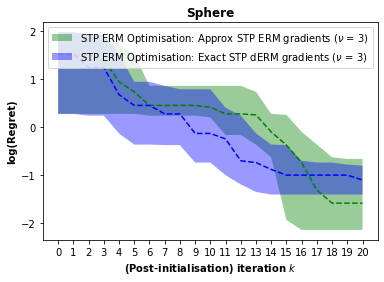

In [123]:
### Visualise!

title = func
plt.figure()

plt.plot(median_approx, color = 'Green', ls='--')
plt.plot(median_exact, color = 'Blue', ls='--')

xstar = np.arange(0, iters+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Green', alpha=0.4, label='STP ERM Optimisation: Approx STP ERM gradients ' r'($\nu$' ' = {})'.format(df))
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Blue', alpha=0.4, label='STP ERM Optimisation: Exact STP dERM gradients ' r'($\nu$' ' = {})'.format(df))

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold')
plt.ylabel('log(Regret)', weight = 'bold') 
plt.legend(loc=1) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show() #visualise!


In [99]:
time_approx, time_exact


(1708.705506324768, 1613.6628093719482)

In [100]:
### acqFunc attribute x, stddev: run number = 1

acqFuncApprox_exact_1 = acqFuncApprox(exact_1.history)
acqFuncExact_exact_1 = acqFuncExact(exact_1.history)

e1 = np.mean(acqFuncExact_exact_1)
a1 = np.mean(acqFuncApprox_exact_1)

e1, a1


(2.8041192629287846, 3.0334378466372653)

In [101]:
### acqFunc attribute x, stddev: run number = 2

acqFuncApprox_exact_2 = acqFuncApprox(exact_2.history)
acqFuncExact_exact_2 = acqFuncExact(exact_2.history)

e2 = np.mean(acqFuncExact_exact_2)
a2 = np.mean(acqFuncApprox_exact_2)

e2, a2


(2.8892180032052033, 2.9114743771173535)

In [102]:
### acqFunc attribute x, stddev: run number = 3

acqFuncApprox_exact_3 = acqFuncApprox(exact_3.history)
acqFuncExact_exact_3 = acqFuncExact(exact_3.history)

e3 = np.mean(acqFuncExact_exact_3)
a3 = np.mean(acqFuncApprox_exact_3)

e3, a3


(2.7541989094284665, 2.9358068986278996)

In [103]:
### acqFunc attribute x, stddev: run number = 4

acqFuncApprox_exact_4 = acqFuncApprox(exact_4.history)
acqFuncExact_exact_4 = acqFuncExact(exact_4.history)

e4 = np.mean(acqFuncExact_exact_4)
a4 = np.mean(acqFuncApprox_exact_4)

e4, a4


(2.7705661242243886, 2.801033485686704)

In [104]:
### acqFunc attribute x, stddev: run number = 5

acqFuncApprox_exact_5 = acqFuncApprox(exact_5.history)
acqFuncExact_exact_5 = acqFuncExact(exact_5.history)

e5 = np.mean(acqFuncExact_exact_5)
a5 = np.mean(acqFuncApprox_exact_5)

e5, a5


(2.901982377119897, 3.0440758592856403)

In [105]:
### acqFunc attribute x, stddev: run number = 6

acqFuncApprox_exact_6 = acqFuncApprox(exact_6.history)
acqFuncExact_exact_6 = acqFuncExact(exact_6.history)

e6 = np.mean(acqFuncExact_exact_6)
a6 = np.mean(acqFuncApprox_exact_6)

e6, a6


(2.9569099373202414, 2.961130091660532)

In [106]:
### acqFunc attribute x, stddev: run number = 7

acqFuncApprox_exact_7 = acqFuncApprox(exact_7.history)
acqFuncExact_exact_7 = acqFuncExact(exact_7.history)

e7 = np.mean(acqFuncExact_exact_7)
a7 = np.mean(acqFuncApprox_exact_7)

e7, a7


(2.871687963830637, 3.0158504352433377)

In [107]:
### acqFunc attribute x, stddev: run number = 8

acqFuncApprox_exact_8 = acqFuncApprox(exact_8.history)
acqFuncExact_exact_8 = acqFuncExact(exact_8.history)

e8 = np.mean(acqFuncExact_exact_8)
a8 = np.mean(acqFuncApprox_exact_8)

e8, a8


(2.727641085974619, 2.994636424505779)

In [108]:
### acqFunc attribute x, stddev: run number = 9

acqFuncApprox_exact_9 = acqFuncApprox(exact_9.history)
acqFuncExact_exact_9 = acqFuncExact(exact_9.history)

e9 = np.mean(acqFuncExact_exact_9)
a9 = np.mean(acqFuncApprox_exact_9)

e9, a9


(2.656083561644922, 3.189498072206677)

In [109]:
### acqFunc attribute x, stddev: run number = 10

acqFuncApprox_exact_10 = acqFuncApprox(exact_10.history)
acqFuncExact_exact_10 = acqFuncExact(exact_10.history)

e10 = np.mean(acqFuncExact_exact_10)
a10 = np.mean(acqFuncApprox_exact_10)

e10, a10


(2.8686233846365865, 3.1025453121762765)

In [110]:
### acqFunc attribute x, stddev: run number = 11

acqFuncApprox_exact_11 = acqFuncApprox(exact_11.history)
acqFuncExact_exact_11 = acqFuncExact(exact_11.history)

e11 = np.mean(acqFuncExact_exact_11)
a11 = np.mean(acqFuncApprox_exact_11)

e11, a11


(2.737320171015634, 2.9906342901733356)

In [111]:
### acqFunc attribute x, stddev: run number = 12

acqFuncApprox_exact_12 = acqFuncApprox(exact_12.history)
acqFuncExact_exact_12 = acqFuncExact(exact_12.history)

e12 = np.mean(acqFuncExact_exact_12)
a12 = np.mean(acqFuncApprox_exact_12)

e12, a12


(2.8575890783556614, 2.855364330980762)

In [112]:
### acqFunc attribute x, stddev: run number = 13

acqFuncApprox_exact_13 = acqFuncApprox(exact_13.history)
acqFuncExact_exact_13 = acqFuncExact(exact_13.history)

e13 = np.mean(acqFuncExact_exact_13)
a13 = np.mean(acqFuncApprox_exact_13)

e13, a13


(2.807522030628097, 3.1128738875699034)

In [113]:
### acqFunc attribute x, stddev: run number = 14

acqFuncApprox_exact_14 = acqFuncApprox(exact_14.history)
acqFuncExact_exact_14 = acqFuncExact(exact_14.history)

e14 = np.mean(acqFuncExact_exact_14)
a14 = np.mean(acqFuncApprox_exact_14)

e14, a14


(2.7993402256926054, 2.9184388941127763)

In [114]:
### acqFunc attribute x, stddev: run number = 15

acqFuncApprox_exact_15 = acqFuncApprox(exact_15.history)
acqFuncExact_exact_15 = acqFuncExact(exact_15.history)

e15 = np.mean(acqFuncExact_exact_15)
a15 = np.mean(acqFuncApprox_exact_15)

e15, a15


(2.6623030701146444, 3.009549197311899)

In [115]:
### acqFunc attribute x, stddev: run number = 16

acqFuncApprox_exact_16 = acqFuncApprox(exact_16.history)
acqFuncExact_exact_16 = acqFuncExact(exact_16.history)

e16 = np.mean(acqFuncExact_exact_16)
a16 = np.mean(acqFuncApprox_exact_16)

e16, a16


(2.7830610994712335, 3.0199019528272717)

In [116]:
### acqFunc attribute x, stddev: run number = 17

acqFuncApprox_exact_17 = acqFuncApprox(exact_17.history)
acqFuncExact_exact_17 = acqFuncExact(exact_17.history)

e17 = np.mean(acqFuncExact_exact_17)
a17 = np.mean(acqFuncApprox_exact_17)

e17, a17


(2.7678056164308438, 3.0193450547550054)

In [117]:
### acqFunc attribute x, stddev: run number = 18

acqFuncApprox_exact_18 = acqFuncApprox(exact_18.history)
acqFuncExact_exact_18 = acqFuncExact(exact_18.history)

e18 = np.mean(acqFuncExact_exact_18)
a18 = np.mean(acqFuncApprox_exact_18)

e18, a18


(2.735408430126173, 2.9592723892506365)

In [118]:
### acqFunc attribute x, stddev: run number = 19

acqFuncApprox_exact_19 = acqFuncApprox(exact_19.history)
acqFuncExact_exact_19 = acqFuncExact(exact_19.history)

e19 = np.mean(acqFuncExact_exact_19)
a19 = np.mean(acqFuncApprox_exact_19)

e19, a19


(2.7764171216491063, 2.906224860230049)

In [119]:
### acqFunc attribute x, stddev: run number = 20

acqFuncApprox_exact_20 = acqFuncApprox(exact_20.history)
acqFuncExact_exact_20 = acqFuncExact(exact_20.history)

e20 = np.mean(acqFuncExact_exact_20)
a20 = np.mean(acqFuncApprox_exact_20)

e20, a20


(2.8852542718231433, 3.1435088103866353)

In [120]:
### Summarize arrays: 

exact_stddev = np.sort([e1,e2,e3,e4,e5,e6,e7,e8,e9,e10,e11,e12,e13,e14,e15,e16,e17,e18,e19,e20])
approx_stddev = np.sort([a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,a20])

np.mean(exact_stddev), np.mean(approx_stddev)


(2.800652586281044, 2.996230123537287)

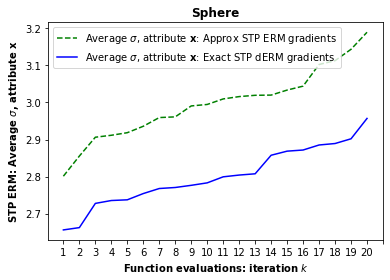

In [121]:
### Visualise!

title = func
plt.figure()

plt.plot(approx_stddev, color = 'Green', ls='--', label='Average $\sigma$, attribute $\mathbf{x}$: Approx STP ERM gradients')
plt.plot(exact_stddev, color = 'Blue', ls='-', label='Average $\sigma$, attribute $\mathbf{x}$: Exact STP dERM gradients')

plt.title(title, weight = 'bold')
plt.xlabel('Function evaluations: iteration $\it{k}$', weight = 'bold')
plt.ylabel('STP ERM: Average $\sigma$, attribute $\mathbf{x}$', weight = 'bold') 
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count))
plt.show() #visualize!
